In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
from collections import namedtuple
import warnings

import torch as t
import numpy as np
import matplotlib.pyplot as plt

from transformers import GPT2TokenizerFast
from transformers.models.gpt2.tokenization_gpt2_fast import GPT2TokenizerFast
import datasets

from gpt import GPT2, get_pretrained_gpt, Corruption, Patch
from hook_handler import HookHandler

In [84]:
device = "cpu" #"cuda" if t.cuda.is_available() else "cpu"
print(f"using {device}")

using cpu


In [82]:
gpt = get_pretrained_gpt(size="base")
gpt.to(device)
gpt.eval();
tokenizer = gpt.tokenizer

/home/ubuntu/.local/lib/python3.8/site-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


In [41]:
gpt.generate("The problem with modern culture is", temperature=.8, device=device)

"The problem with modern culture is that you can't have the very best and badest of them at once. The show from the '80s is brilliant, but it's not"

In [42]:
def most_likely(model, fact, k=5):
    subject_ids = tokenizer.encode(fact.subject, return_tensors="pt").to(device)
    relation_ids = tokenizer.encode(fact.relation, return_tensors="pt").to(device)
    input_ids = t.cat((subject_ids, relation_ids), dim=1)
    model_out = model(input_ids)
    target_probs = t.softmax(model_out.logits.squeeze(0), dim=0)
    top_probs, top_ids = t.topk(target_probs, k=k)
    for i in range(k):
        token = tokenizer.decode(top_ids[i])
        print(f"{repr(token).ljust(15)}{top_probs[i]:.2%}")

In [43]:
Fact = namedtuple("Fact", ['subject', 'relation', 'object'])
example_facts = [
    Fact("Pelé", " plays the sport of", " soccer"),
    Fact("The Eiffel Tower", " is in the city of", " Paris")
]

Input:
'P' 'el' 'é' ' used' ' to' ' play' ' the' ' sport' ' of' 

Prob ability of the correct answer (' soccer')
normal gpt: 15.41%
corrupted:  1.43%


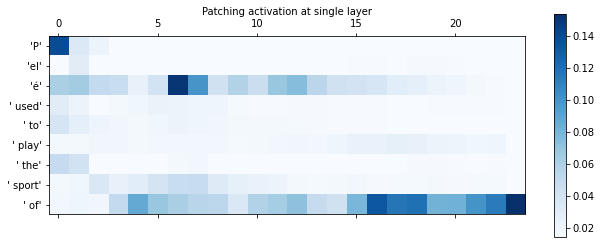

In [75]:
def get_correct_prob(out, correct_id):
    return t.softmax(out.logits[0], dim=-1)[correct_id].item()


def print_tokenized(ids):
    l = tokenizer.batch_decode([[id] for id in ids])
    for t in l:
        print(repr(t), end=" ")
    print()


def run_baseline(model, input_ids, correct_id):
    with HookHandler() as hh:
        for i, block in enumerate(model.blocks):
            hh.add_save_activation_hook(block, key=i)

        logits = model(input_ids)
        correct_prob = get_correct_prob(logits, correct_id)
        return hh.activations, correct_prob


def avg_evaluate(model, input_ids, correct_id, k=5, **kwargs):
    probs = []
    seeds = range(k)
    for seed in seeds:
        t.manual_seed(seed)
        corrupt_out = model.forward_corrupt_and_patch(input_ids, **kwargs)
        probs.append(get_correct_prob(corrupt_out, correct_id))
    return sum(probs) / k

def fact_tensors(fact, tokenizer):
    if fact.relation[0] != " ":
        warnings.warn(f"The fact relation {fact.relation} does not start with a space")
    if fact.object[0] != " ":
        warnings.warn(f"The fact object {fact.object} does not start with a space")

    subject_ids = tokenizer.encode(fact.subject, return_tensors="pt").to(device)
    relation_ids = tokenizer.encode(fact.relation, return_tensors="pt").to(device)
    subj_len = subject_ids.shape[1]
    input_ids = t.cat((subject_ids, relation_ids), dim=1)

    correct_id = tokenizer.encode(fact.object)
    if len(correct_id) != 1:
        warnings.warn(
            f"The fact object {fact.object} is {len(correct_id)} tokens long, only using first token"
        )
    correct_id = correct_id[0]

    return input_ids, subj_len, correct_id


def patching(
    model: GPT2, tokenizer, fact: Fact, k=3, noise_std=0.4, plot=True
):
    input_ids, subj_len, correct_id = fact_tensors(fact, tokenizer)
    activations, p_baseline = run_baseline(model, input_ids, correct_id)

    corruption = Corruption(subj_len, noise_std)
    p_corrupted = avg_evaluate(
        model,
        input_ids=input_ids,
        correct_id=correct_id,
        k=k,
        corruption=corruption,
    )
    
    print(f"Input:")
    print_tokenized(input_ids[0])

    print(f"\nProb ability of the correct answer ({repr(fact.object)})")
    print(f"normal gpt: {p_baseline:.2%}")
    print(f"corrupted:  {p_corrupted:.2%}")

    n_layers = len(model.blocks)
    n_tokens = input_ids.shape[1]
    avg_prob = np.zeros((n_tokens, n_layers))
    for token in range(n_tokens):
        for layer in range(n_layers):
            patch_value = activations[layer][0, token]
            patch = Patch(type="act", token=token, layer=layer, value=patch_value)
            prob = avg_evaluate(
                model,
                input_ids=input_ids,
                correct_id=correct_id,
                k=k,
                patch=patch,
                corruption=corruption,
            )
            avg_prob[token, layer] = prob

    if plot:
        plt.matshow(avg_prob, vmin=p_corrupted, vmax=p_baseline, cmap="Blues")
        l = tokenizer.batch_decode([[id] for id in input_ids[0]])
        plt.yticks(ticks=range(n_tokens), labels=[repr(t) for t in l])
        plt.xlabel("Patching activation at single layer")
        plt.gca().xaxis.set_label_position("top")
        plt.colorbar()
    return avg_prob

probs = patching(
    gpt, tokenizer, example_facts[0], k=3
)

In [45]:
most_likely(gpt, example_facts[0])

' soccer'      15.41%
' football'    9.09%
' basketball'  6.96%
' boxing'      6.14%
' tennis'      5.64%


# Rank-One Model Editing

## Finding C and k*

In [33]:
gpt.blocks[3].linear2

Linear(in_features=4096, out_features=1024, bias=True)

In [27]:
dataset = datasets.load_dataset('wikitext', 'wikitext-2-v1', split='train')
dataset = dataset.map(lambda e: tokenizer(e['text'], truncation=True))
dataset.set_format(type='torch', columns=['text', 'input_ids'])

Reusing dataset wikitext (/home/ubuntu/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


  0%|          | 0/36718 [00:00<?, ?ex/s]

In [31]:
len(dataset)

36718

In [58]:
def estimate_C(model, layer, dataset):
    linear = model.blocks[layer].linear2
    
    with HookHandler() as hh:
        hh.add_save_input_hook(linear)

        for input_ids in dataset['input_ids'][:1000]:
            if input_ids.shape[0] > 0:
                input_ids = input_ids.unsqueeze(0).to(device)
                model(input_ids)
        
        input_tensor = t.cat(hh.inputs, dim=1).squeeze(0).T
    print(input_tensor.shape)
    C = t.cov(input_tensor)

c9 = estimate_C(gpt, 9, dataset)

torch.Size([4096, 62765])


In [59]:
def get_k_star(model, layer, fact):
    linear = model.blocks[layer].linear2
    with HookHandler() as hh:
        hh.add_save_input_hook(linear)
        input_ids = tokenizer.encode(fact.subject, return_tensors="pt").to(device)
        model(input_ids)
        return hh.inputs[0][0,-1,:]

get_k_star(gpt, 9, example_facts[0])

tensor([-0.1049, -0.1267, -0.0477,  ..., -0.0048, -0.0840, -0.0669],
       device='cuda:0')

## Optimizing for v

In [89]:
def get_z_star(model: GPT2, layer: int, fact: Fact, new_obj: str):
    input_ids, subj_len, _ = fact_tensors(fact, tokenizer) 
    new_obj_id = tokenizer.encode(new_obj, return_tensors='pt')
    assert len(new_obj_id) == 1
    new_obj_id = new_obj_id[0].to(device)

    z = t.randn(model.hidden_size, device=device, requires_grad=True)
    optim = t.optim.SGD([z], lr=1e-1)
    for step in range(100):
        optim.zero_grad()
        patch = Patch("mlp", subj_len, 9, z)
        out = model.forward_corrupt_and_patch(input_ids, patch=patch)
        new_obj_prob = out.logits.softmax(dim=-1)[0, new_obj_id]
        loss = - t.log(new_obj_prob)
        loss.backward()
        optim.step()
        
        if step % 10 == 0:
            print(loss.item())

get_z_star(gpt, 9, example_facts[0], " baseball")

9.089139938354492
9.088784217834473
9.088382720947266
9.088030815124512
9.087662696838379
9.087302207946777


In [85]:
gpt.to(device);